# Etude de la géostrophie dans des données de modèle dans la région du Gulf Stream

In [1]:
import numpy as np
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from tools import *

import seaborn as sns

In [2]:
#Fonction pour tracer les ellipses 
#Guillaume Maze tous droits réservés 


def plot_GMMellipse0(gmm,id,ik,col,ax,label=""):
    """
        Plot an 1-STD ellipse for a given component (ik) and 2 dimensions (id) 
        of the GMM model gmm
        This is the class routine, using the matplotlib Ellipse method
        I don't like it because the Ellipse object cannot be labelled...
    """
    covariances = gmm.covariances_[ik][(id[0],id[0],id[1],id[1]),(id[0],id[1],id[0],id[1])].reshape(2,2)
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi 
    v = 2. * np.sqrt(v)
    ell = mpl.patches.Ellipse(gmm.means_[ik,(id[0],id[1])], v[0], v[1],180 + angle,\
                                         fill=False,label=label)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(1)
    ell.set_label("Class #%i"%(ik))
#    ell.set_facecolor(color)
    ell.set_edgecolor(col)
    ell.set_linewidth(2)
    ax.add_artist(ell)
    return ell,ax

def plot_GMMellipse(gmm,id,ik,col,ax,label="",std=[1],main_axes=True,**kwargs):
    """
        Plot an 1-STD ellipse for a given component (ik) and 2 given dimensions (id) 
        of the GMM model gmm
        This is my routine, simply working with a matplotlib plot method
        I also added the possiblity to plot the main axes of the ellipse
    """
    covariances = gmm.covariances_[ik][(id[0],id[0],id[1],id[1]),(id[0],id[1],id[0],id[1])].reshape(2,2)
    d, v = np.linalg.eigh(covariances) #  eigenvectors have unit length
    d = np.diag(d)
    theta = np.arange(0,2*np.pi,0.02)
    x = np.sqrt(d[0,0])*np.cos(theta)
    y = np.sqrt(d[1,1])*np.sin(theta)
    xy = np.array((x,y)).T
    ii = 0
    for nstd in np.array(std):
        ii+=1
        ellipse = np.inner(v,xy).T
        ellipse = nstd*ellipse + np.ones((theta.shape[0], 1))*gmm.means_[ik,(id[0],id[1])]
        if ii == 1:
#            p = ax.plot(ellipse[:,0], ellipse[:,1], color=col, axes=ax, label=("%s (%i-std)")%(label,nstd),**kwargs)
            p = ax.plot(ellipse[:,0], ellipse[:,1], color=col, axes=ax, label=("%s")%(label),**kwargs)
        else:
            p = ax.plot(ellipse[:,0], ellipse[:,1], color=col, axes=ax,**kwargs)
    if main_axes: # Add Main axes:
        for idir in range(2):
            l = np.sqrt(d[idir,idir])*v[:,idir].T
            start = gmm.means_[ik,(id[0],id[1])]-l
            endpt = gmm.means_[ik,(id[0],id[1])]+l
            linex = [start[0], endpt[0]]
            liney = [start[1], endpt[1]]
            plt.plot(linex,liney,color=col,axes=ax)
    return p,ax

On étudie des sorties du modèle CROCO dans la région du Gulf Stream 

Résolution : 1/3°

Pas de temps des sorties : 3 jours

In [3]:
#importation des données

ncfile = 'C:/Users/Charly/Desktop/M2 POC/Mod_Num_Haut/CROCO_FILES/croco_his.nc'
nc = Dataset(ncfile)
print(nc.variables.keys())

odict_keys(['spherical', 'xl', 'el', 'xi_rho', 'xi_u', 'eta_rho', 'eta_v', 'Vtransform', 's_rho', 's_w', 'sc_r', 'sc_w', 'Cs_r', 'Cs_w', 'hc', 'h', 'f', 'pm', 'pn', 'lon_rho', 'lat_rho', 'lon_u', 'lat_u', 'lon_v', 'lat_v', 'angle', 'mask_rho', 'time_step', 'scrum_time', 'time', 'zeta', 'ubar', 'vbar', 'u', 'v', 'temp', 'salt', 'w', 'bostr', 'wstr', 'sustr', 'svstr', 'AKt', 'hbl', 'hbbl', 'shflux', 'swflux', 'swrad'])


In [4]:
#Lecture et définition des différentes variables

#s=nc.variables['s_rho'][:]
hc=nc.variables['hc'][:]
Cs_r=nc.variables['Cs_r'][:]
Cs_w=nc.variables['Cs_w'][:]
x_rho = nc.variables['xi_rho'][:] #grille pour traceurs
y_rho = nc.variables['eta_rho'][:]
x_u = nc.variables['xi_u'][:] #grille pour u
y_v = nc.variables['eta_v'][:]  #grille pour v
u_tmp = nc.variables['u'][:]
v_tmp = nc.variables['v'][:]
zeta = nc.variables['zeta'][:]
h= nc.variables['h'][:]
f= nc.variables['f'][:]
temp=nc.variables['temp'][:]
mask=nc.variables['mask_rho'][:]
salt= nc.variables['salt'][:]

lon=nc.variables['lon_rho'][:]
lat=nc.variables['lat_rho'][:]
XX_rho,YY_rho=np.meshgrid(x_rho,y_rho)
XX_uv,YY_uv=np.meshgrid(x_u,y_v)


print ("dimension typique d'un tableau ",temp.shape)

dimension typique d'un tableau  (224, 32, 114, 136)


In [5]:
#petit traitement sur les dimensions de certains tableaux

lx=114
ly=136

u=0.5*(u_tmp[:,:,1:,:]+u_tmp[:,:,0:-1,:])
v=0.5*(v_tmp[:,:,:,1:]+v_tmp[:,:,:,0:-1])
lon_uv=np.copy(lon[0:lx-1,0:ly-1])
lat_uv=np.copy(lat[0:lx-1,0:ly-1])
lon_cut=np.copy(lon[0,:])
lat_cut=np.copy(lat[:,0])



In [ ]:
# affichage vitesse sur un pas de temps :
i=10
zeta_t=np.copy(zeta[i,:,:])
u_surf_t=np.copy(u[i,31,:,:])
v_surf_t=np.copy(v[i,31,:,:])


plt.figure()
plt.pcolormesh(XX_rho,YY_rho,zeta_t)
plt.quiver(XX_uv,YY_uv,u_surf_t,v_surf_t)
plt.show()

# Equation à étudier  ${\rm \partial_y  \Big( \beta_T \int_{zref}^z dz T\Big)=  \partial_y \eta }$

cette relation est vraie tant que ${\rm |u(z_{ref}|=0}$

on pose ${\rm \bar{T} = \int_{zref}^z  T  dz}$

On dispose de deux dimensions : 

${\rm X_1=\beta_T \nabla \bar{T}}$ 

et 

${\rm X_2=\nabla \eta }$

Dans l'espace de ces deux paramètres, on va rechercher des classes pour identifier ce qui est géostrophique et ce qu'il ne l'est pas. En particulier, on devrait avoir un mode ou ${\rm X_1 \sim X_2 }$ qui correspond au mode géostrophique, le reste devant correspondre à des zones turbulentes ou no ajustées géostrophiquement.

### Calcul de ${\rm \bar{T}}$

In [6]:
#Calcul des niveaux moyens (+simple) car on est en coordonnes sigma (les niveaux suivent la topo)

tmp=np.zeros((temp[:,:,:,:].shape))
for i in range (len(zeta[:,0,0])):
    z_r,z_w=zlevs(h,zeta[i,:,:], hc, Cs_r, Cs_w)
    tmp[i]=z_r
    
z=np.copy(tmp)
zmoy=np.mean(tmp,axis=0)

#calcul du dz pour l'integrale

ztotal=np.zeros((33,114,136))

ztotal[0,:,:]=-(h+np.mean(zeta,axis=0))
ztotal[1:,:,:]=zmoy

dz=np.diff(ztotal,axis=0)

#calcul de l'integrale en faisant une cumsum pour avoir l'integrale entre le fond et le niveaux considéré

Tbar_lev=np.zeros(temp.shape)
Tbar_lev=np.cumsum(temp[:,:,:,:]*dz[:,:,:], axis=1)

In [8]:
#Il faut enlever le Tbar au niveau de reference --> on interpole au niveau de reference

Tbar_surf=np.copy(Tbar_lev[:,31,:,:]) #niveau de surface

###
#soit on prend un niveau de reference et on interpole  Tbar=Tbar_surf-Tbar_zref
###

#zref=-1000

#Tbar_zref=np.zeros(Tbar_surf.shape)

#for i in range (len(Tbar_zref[:,0,0])):
#    z_r,z_w=zlevs(h,zeta[i,:,:], hc, Cs_r, Cs_w)   
#    Tbar_zref[i,:,:]=vinterp(Tbar_lev[i,:,:,:],z_r,zref,topo=h)

#Tbar_zref=np.nan_to_num(Tbar_zref)

###
#soit on enleve un niveau sigma donné
#ici ou le gulfstream decroche du talus, z_fond=-4000, et z_ref=-1000 : ça correspond au 8eme niveau sigma : on prend ça,
#mais cette approximation est surment la cause de certains problèmes dans la suite
###

Tbar=Tbar_surf-Tbar_lev[:,8,:,:]

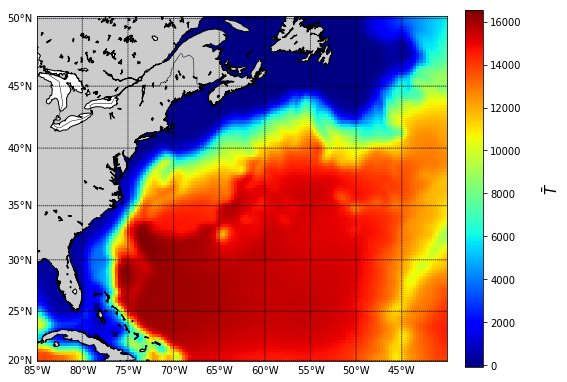

In [10]:
#tracé de Tbar sur le domaine a un temps donné

plt.figure(figsize=(8,8))
plt.subplot(111)
map = Basemap(llcrnrlon=lon_cut.min(),llcrnrlat=lat_cut.min(),urcrnrlon=lon_cut.max(),urcrnrlat=lat_cut.max(),resolution='i',projection='merc')
map.fillcontinents()
map.drawcoastlines()
map.drawcountries()
parallels = np.arange(lat_cut.min(),lat_cut.max(),5)
map.drawparallels(parallels,labels=[True,False,True,False])
meridians=np.arange(lon_cut.min(),lon_cut.max(),5)
map.drawmeridians(meridians,labels=[True,False,False,True])

xmap, ymap = map(lon, lat)


pc=map.pcolormesh(xmap,ymap,Tbar[10,:,:],cmap='jet')#,vmin=-5,vmax=0)
cbar=plt.colorbar(pc,fraction=0.04, pad=0.04)
cbar.set_label(r"$\bar{T}$ ", fontsize=15, rotation=90,labelpad=20)

plt.show()

Ce tracé nous renseigne sur le "contenu thermique de l'ocean" a un instant donné a chaque point de grille

In [11]:
#Fonction de calcul de gradient en prenant en compte les changements de dx et dy a cause de la sphericité: 

def gradient (U,lon,lat):
    
    #calcul dx et dy

    lat_tmp=np.copy(lat[:,:])
    lon_tmp=np.copy(lon[:,:])


    R=6371.*1000
    dy_tmp=(lat_tmp[1:,:]-lat_tmp[0:-1,:])*(np.pi/180.)*R
    dy=np.copy(dy_tmp[:,:-1])
    dx_tmp=R*np.cos(lat_tmp[:,1:]*(np.pi/180.))*(lon_tmp[:,1:]-lon_tmp[:,0:-1])*(np.pi/180.)
    dx=np.copy(dx_tmp[:-1,:])
    
    
    
    
    gradx_U_tmp    = (U[:,:,1:]-U[:,:,:-1])
    gradx_U=.5*(gradx_U_tmp[:,1:,:]+gradx_U_tmp[:,0:-1,:])
    grady_U_tmp    = (U[:,1:,:]-U[:,:-1,:]  )
    grady_U=.5*(grady_U_tmp[:,:,1:]+grady_U_tmp[:,:,0:-1])

   
    #dx=30*1000.
    #dy=30*1000.
    
    gradx_U=gradx_U/dx
    grady_U=grady_U/dy
    
    return gradx_U,grady_U


### Calcul des gradients des deux quantités

In [12]:
#Calcul des gradients 
gradx_zeta,grady_zeta=gradient(zeta,lon,lat)
gradx_Tbar,grady_Tbar=gradient(Tbar,lon,lat)

A cause du gradient, on va avoir des valeurs aux bords qui ne vont pas : on modifie le masque donné par croco pour exclure les bords des continents 

In [13]:
mask_grad1=np.zeros(mask.shape)
mask_grad2=np.zeros(mask.shape)
mask_grad3=np.zeros(mask.shape)
mask_grad=np.zeros(mask.shape)
tmask=2

mask_grad1[tmask:,tmask:]=mask[:-tmask,:-tmask]
mask_grad2[:-tmask,:-tmask]=mask[tmask:,tmask:]


mask_grad=mask_grad1*mask_grad2


Dans un premier temps, on regarde une petite zone sur le plateau de floride, car le flot est probablement géostrophique dans cette région

In [14]:
#On choisit la petite zone
#--> on créé un petit mask qu'on combine à l'autre

mask_tmp=np.copy(mask_grad)
mask_tmp=np.where(lat>35,0,mask_tmp)
mask_tmp=np.where(lat<30,0,mask_tmp)
mask_tmp=np.where(lon<-80,0,mask_tmp)
mask_tmp=np.where(lon>-75,0,mask_tmp)

mask_grad_zone=mask_tmp

In [15]:
#On applique le masque aux champs :
gradx_zeta_mask=np.where(mask_grad_zone[1:,1:]==1,gradx_zeta,0)
gradx_Tbar_mask=np.where(mask_grad_zone[1:,1:]==1,gradx_Tbar,0)
grady_zeta_mask=np.where(mask_grad_zone[1:,1:]==1,grady_zeta,0)
grady_Tbar_mask=np.where(mask_grad_zone[1:,1:]==1,grady_Tbar,0)
#calcul les normes des gradients pour avoir un champs scolaire
grad_zeta=np.sqrt(gradx_zeta_mask**2+grady_zeta_mask**2)
grad_Tbar=np.sqrt(gradx_Tbar_mask**2+grady_Tbar_mask**2)

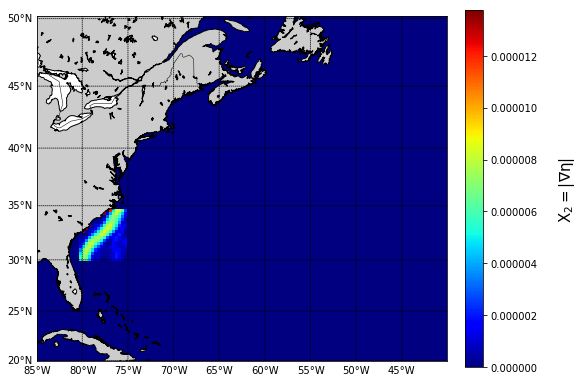

In [19]:
plt.figure(figsize=(8,8))
plt.subplot(111)
map = Basemap(llcrnrlon=lon_cut.min(),llcrnrlat=lat_cut.min(),urcrnrlon=lon_cut.max(),urcrnrlat=lat_cut.max(),resolution='i',projection='merc')
map.fillcontinents()
map.drawcoastlines()
map.drawcountries()
parallels = np.arange(lat_cut.min(),lat_cut.max(),5)
map.drawparallels(parallels,labels=[True,False,True,False])
meridians=np.arange(lon_cut.min(),lon_cut.max(),5)
map.drawmeridians(meridians,labels=[True,False,False,True])

xmap, ymap = map(lon, lat)


#pc=map.pcolormesh(xmap,ymap,np.where(grad_zeta[10,:,:]>0.00001,0,grad_zeta[10,:,:]),cmap='jet')#,vmin=0,vmax=0)
#pc=map.pcolormesh(xmap,ymap,grad_zeta[10,:,:],cmap='jet')#,vmin=0,vmax=0)
pc=map.pcolormesh(xmap,ymap,grad_zeta[150,:,:],cmap='jet')#,vmin=0,vmax=0)
cbar=plt.colorbar(pc,fraction=0.04, pad=0.04)
cbar.set_label(r"${\rm X_2=|\nabla \eta|}$ ", fontsize=15, rotation=90,labelpad=20)

plt.show()

On obtient bien un gradient important où la pente est forte à cause du gulf stream

Si on veut calculer ${\rm X_1}$ il faut ${\rm \beta_T}$. Ce paramètre dépend de la température et de la salinité a chaque pas de temps et a chaque pas de grille : on le calcul avec la librairie gsw

In [17]:
#from gsw import alpha_wrt_t_exact
import gsw

salt_surf=np.copy(salt[:,31,:,:])
SA_surf=gsw.SA_from_SP(salt_surf,0,lon,lat)
beta=gsw.alpha_wrt_t_exact(salt_surf,temp[:,31,:,:],0)

#on applique le masque a beta
beta=np.where(mask_grad[:,:]==1,beta,0)
beta=np.where(beta<0,0,beta)



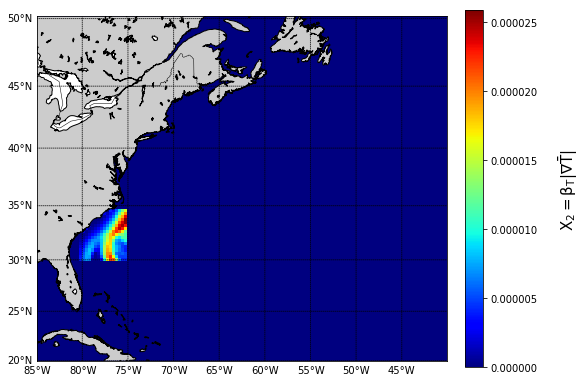

In [20]:
plt.figure(figsize=(8,8))
plt.subplot(111)
map = Basemap(llcrnrlon=lon_cut.min(),llcrnrlat=lat_cut.min(),urcrnrlon=lon_cut.max(),urcrnrlat=lat_cut.max(),resolution='i',projection='merc')
map.fillcontinents()
map.drawcoastlines()
map.drawcountries()
parallels = np.arange(lat_cut.min(),lat_cut.max(),5)
map.drawparallels(parallels,labels=[True,False,True,False])
meridians=np.arange(lon_cut.min(),lon_cut.max(),5)
map.drawmeridians(meridians,labels=[True,False,False,True])

xmap, ymap = map(lon, lat)

#pc=map.pcolormesh(xmap,ymap,grad_Tbar[10,:,:],cmap='jet')#,vmin=0,vmax=0)
pc=map.pcolormesh(xmap,ymap,beta[150,1:,1:]*grad_Tbar[150,:,:],cmap='jet')#,vmin=0,vmax=0)
cbar=plt.colorbar(pc,fraction=0.04, pad=0.04)
cbar.set_label(r"${\rm X_2=\beta_T|\nabla \bar{T}|}$ ", fontsize=15, rotation=90,labelpad=20)

plt.show()

On retrouve le front, mais le long du talus la profondeur est plus importante donc on a plus de contenu thermique : ça créé un front le long du talus --> problème ?

## Analyse du jeu de données

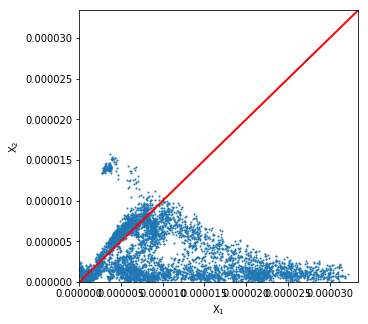

In [23]:
#On définit les deux dimensions
X1=grad_Tbar*beta[:,1:,1:] ###La premire dimension
X2=grad_zeta[:,:,:] ### La deuxieme dimension

X1_flat=X1[200:,:,:].flatten()
X2_flat=X2[200:,:,:].flatten()


maxplot=np.max(np.absolute(np.array([np.min(X1),np.min(X2),np.max(X1),np.max(X2)]))) #pour le plot
plt.figure(figsize=(5,5))

plt.plot(X1_flat,X2_flat,'o',markersize=1)

plt.plot([-1,1],[-1,1],'-r',linewidth=2)

plt.axis([0,maxplot,0,maxplot])

plt.xlabel(r'${\rm X_1}$')
plt.ylabel(r'${\rm X_2}$')

plt.show()

BON POINT : l'ordre de grandeur des deux dimensions est équivalent : c'est encourageant pour la suite

Il semberait qu'un certain nombre de valeurs soient situées le long de la droite de pente 1 --> mode géostrophique ???

In [24]:
#On enlève les valeurs ou les gradients sont nuls pour ne pas regarder les zones où rien ne se passe : 

eps=maxplot/40.

X1_nozero1=X1_flat[X1_flat>eps]
X2_nozero1=X2_flat[X1_flat>eps]

X1_nozero=X1_nozero1[X2_nozero1>eps]
X2_nozero=X2_nozero1[X2_nozero1>eps]

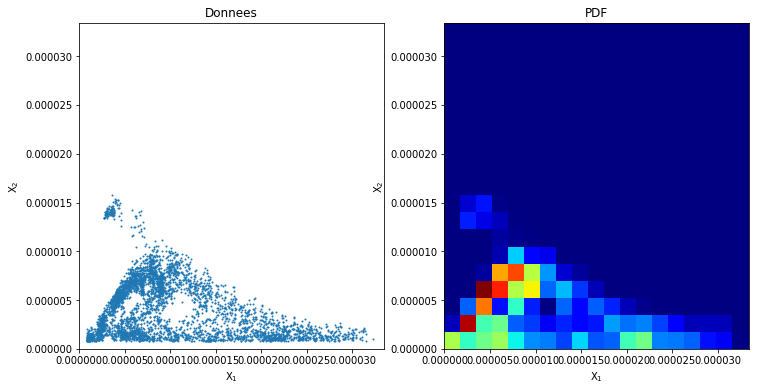

In [30]:
plt.figure(figsize=(12,6))
ax1=plt.subplot(121)
plt.plot(X1_nozero,X2_nozero,'o',markersize=1)
plt.axis([0,maxplot,0,maxplot])
plt.xlabel(r'${\rm X_1}$')
plt.ylabel(r'${\rm X_2}$')
plt.title("Donnees")



ax2=plt.subplot(122)
N=20
x1_hist=np.linspace(0,maxplot,N)
x2_hist=np.linspace(0,maxplot,N)
H,xedges,yedges=np.histogram2d(X2_nozero,X1_nozero,bins=(x1_hist,x2_hist),normed=True)
plt.pcolor(xedges,yedges,H,vmin=0,vmax=np.max(H),cmap='jet')
plt.xlabel(r'${\rm X_1}$')
plt.ylabel(r'${\rm X_2}$')
plt.title("PDF")
plt.show()

Il semble bien aux vues de la pdf qu'il y ai quelque chose sur la diagonale

# FOUILLE de données

In [31]:
from sklearn import datasets, linear_model, mixture, neighbors,cluster

## Regression

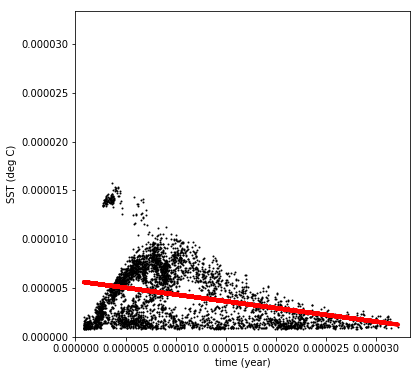

In [33]:
#Avec scikit

X_Reg=np.ones((len(X1_nozero),2))
X_Reg[:,1]=X1_nozero
#Y_Rec=X2_nozero

regr = linear_model.LinearRegression(fit_intercept=False)

regr.set_params(fit_intercept=1)

# Train the model using the training sets
regr.fit(X_Reg, X2_nozero)

# Make predictions using the testing set
X2_predict = regr.predict(X_Reg)

plt.figure(figsize=(6,6))
plt.plot(X1_nozero,X2_nozero,'ok',linewidth=1,markersize=1)
plt.plot(X1_nozero,X2_predict,'-r',linewidth=4)
plt.axis([0,maxplot,0,maxplot])
plt.xlabel('time (year)')
plt.ylabel('SST (deg C)')
plt.show()

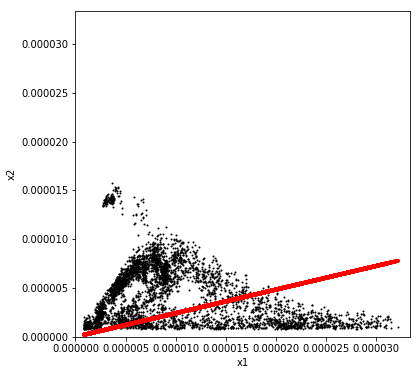

In [34]:
#avec curve_fit

from scipy.optimize import curve_fit

def func (x,a):
    return a*x

popt, pcov = curve_fit(func,X1_nozero,X2_nozero,1)

plt.figure(figsize=(6,6))
plt.plot(X1_nozero,X2_nozero,'ok',linewidth=1,markersize=1)
plt.plot( X1_nozero, func(X1_nozero,popt[0]), '-r',linewidth=4)
plt.axis([0,maxplot,0,maxplot])
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Pas très convaincant vu la disparité des données

## CLUSTERING pour repérer où c'est geostrophique (si tout va bien)


### Phase d'entrainement sur la petite zone

1.93087492643

 Mode/class/component/cluster ID# 0
center :  [ 0.44220763  0.15387   ]
covariance :  [[ 0.01851792 -0.00725441]
 [-0.00725441  0.00388433]]
weight (prior) :  0.16681160021

 Mode/class/component/cluster ID# 1
center :  [ 0.11392179  0.13234584]
covariance :  [[ 0.00226924  0.00291669]
 [ 0.00291669  0.00406198]]
weight (prior) :  0.209406014235

 Mode/class/component/cluster ID# 2
center :  [ 0.43878609  0.04345178]
covariance :  [[ 0.06532976 -0.00019153]
 [-0.00019153  0.00017177]]
weight (prior) :  0.317992681425

 Mode/class/component/cluster ID# 3
center :  [ 0.22652013  0.20081644]
covariance :  [[ 0.00393079 -0.00164878]
 [-0.00164878  0.00878369]]
weight (prior) :  0.30578970413


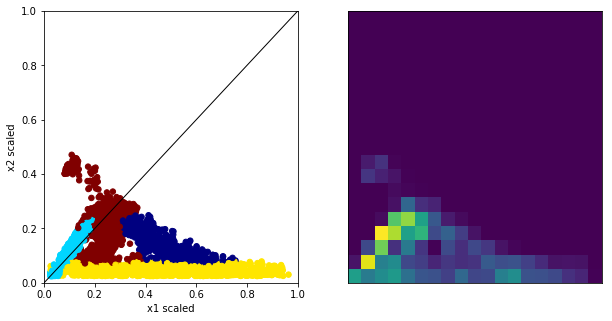

In [35]:
nb=1

data=np.array([X1_nozero[::nb]/maxplot,X2_nozero[::nb]/maxplot]).T

#nombre de clusters
K=4

gmm=mixture.GaussianMixture(n_components=K)
gmm.fit(data)

#final log likehood of the dataset
print (gmm.score(data))

k=0
for pos,covar,w in zip(gmm.means_,gmm.covariances_,gmm.weights_):
    print ( '\n Mode/class/component/cluster ID#',k)
    print ( 'center : ',pos)
    print ( 'covariance : ',covar)
    print ( 'weight (prior) : ',w)
    k=k+1



posts=gmm.predict_proba(data)
labels=gmm.predict(data)

#print (labels)

plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
ax1.scatter(data[:,0], data[:,1],c=labels,s=30,cmap='jet')
ax1.axis([0,1,0,1])
ax1.plot([-1,1],[-1,1],'-k',linewidth=1)
plt.xlabel('x1 scaled')
plt.ylabel('x2 scaled')

ax2 = plt.subplot(122)
x1_hist=np.linspace(0,1,N)
x2_hist=np.linspace(0,1,N)
H,xedges,yedges=np.histogram2d(data[:,1],data[:,0],bins=(x1_hist,x2_hist),normed=True)
ax2.pcolor(xedges,yedges,H,vmin=0,vmax=np.max(H))
plt.xticks([])
plt.yticks([])


plt.show()

On a une classe sur la diagonale !! 

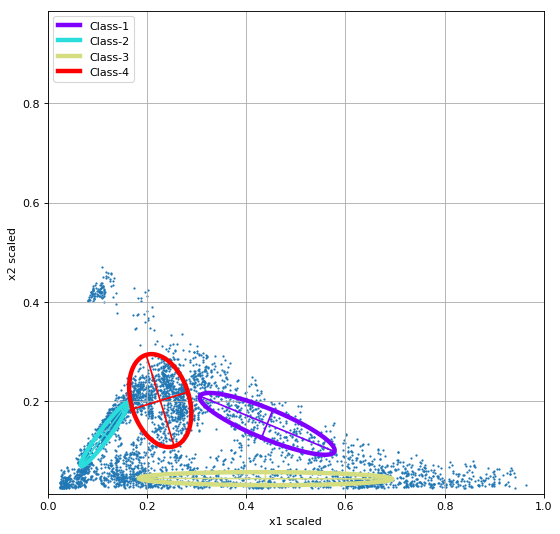

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')
id = np.array([1,2])-1
ax.scatter(data[:,id[0]],data[:,id[1]],1)
ax.grid(True)
ax.axis('equal')
plt.xlabel('x1 scaled')
plt.ylabel('x2 scaled')
colors = mpl.colors.cnames.items()
colors = iter(plt.cm.rainbow(np.linspace(0, 1, K)))
for ik in np.arange(K):
#    el,ax = plot_GMMellipse0(gmm,id,ik,colors[ik][0],ax,label="Class-%i"%(ik+1))
    el,ax = plot_GMMellipse(gmm,id,ik,next(colors),ax,label="Class-%i"%(ik+1),linewidth=4)
#    el,ax = plot_GMMellipse(gmm,id,ik,next(colors),ax,label="Class-%i"%(ik+1),std=[1],linewidth=4)
ax.legend(loc='upper left')
plt.axis([0,1,0,1])
plt.show()

Ici le GMM peut servir de remplaçant à la regression : le grand axe de l'ellipse de la classe 2 (sur la diagonale) permet d'avoir une valeur du fit : proche de 1 ou pas ?

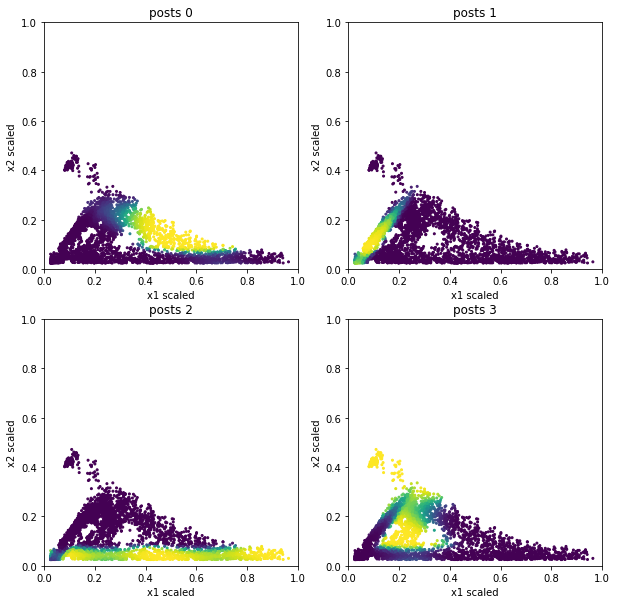

In [37]:
#robustness et posteriors 

robust=(np.max(posts,axis=1)-1./K)*K/(K-1.)

plt.figure(figsize=(10,10))
ax1=plt.subplot(221)
ax1.scatter(data[:,0],data[:,1],c=posts[:,0],cmap='viridis',s=4)
plt.axis([0,1,0,1])
plt.xlabel('x1 scaled')
plt.ylabel('x2 scaled')
plt.title('posts 0')

ax2=plt.subplot(222)
ax2.scatter(data[:,0],data[:,1],c=posts[:,1],cmap='viridis',s=4)
plt.axis([0,1,0,1])
plt.xlabel('x1 scaled')
plt.ylabel('x2 scaled')
plt.title('posts 1')

ax2=plt.subplot(223)
ax2.scatter(data[:,0],data[:,1],c=posts[:,2],cmap='viridis',s=4)
plt.axis([0,1,0,1])
plt.xlabel('x1 scaled')
plt.ylabel('x2 scaled')
plt.title('posts 2')

ax2=plt.subplot(224)
ax2.scatter(data[:,0],data[:,1],c=posts[:,3],cmap='viridis',s=4)
plt.axis([0,1,0,1])
plt.xlabel('x1 scaled')
plt.ylabel('x2 scaled')
plt.title('posts 3')


plt.show()



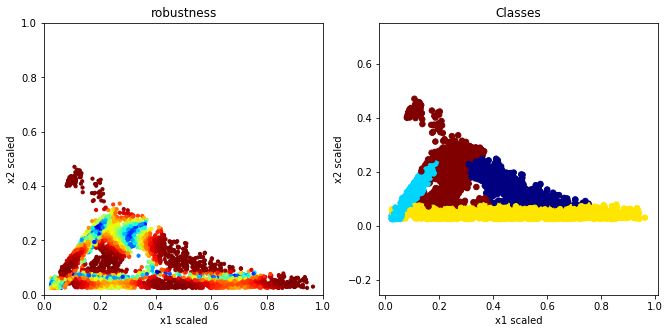

In [39]:
plt.figure(figsize=(11,5))

ax1=plt.subplot(1,2,1)

plt.scatter(data[:,0],data[:,1],c=robust,cmap='jet',s=10)
plt.axis([0,1,0,1])
#plt.colorbar()
plt.title("robustness")
plt.xlabel('x1 scaled')
plt.ylabel('x2 scaled')

ax2=plt.subplot(1,2,2)
plt.axis([0,1,0,1])
ax2.axis('equal')
ax2.scatter(data[:,0], data[:,1],c=labels,s=30,cmap='jet')
plt.title("Classes")
plt.xlabel('x1 scaled')
plt.ylabel('x2 scaled')
plt.show()

### Nombre de cluster ideal avec le BIC

Pour calculer le BIC on regarde le nombre de points indépendants aussi bien dans l'espace que dans le temps
Ici on a considéré un domaine de 5°x5° avec une resolution au 1/3° : on a alors une grille de 15x15 et des sorties tous les 3 jours

Dans cette région, les vitesses sont de l'ordre $1\,m.s^{-1}$, une particule peut donc parcourir jusqu'a 75 km en 3 jours : ce qui revient à 2 pas de grilles entre chaque sortie.

Les données indépendantes sont donc celles qui entre chaque pas de temps sont espacés de plus de 2 pas de grille : si on prend une tous les 11, au vu de la forme du tableau, on décale les points que l'on prend entre qhaque pas de temps

plus clair en dessous, on prend que les points à 1

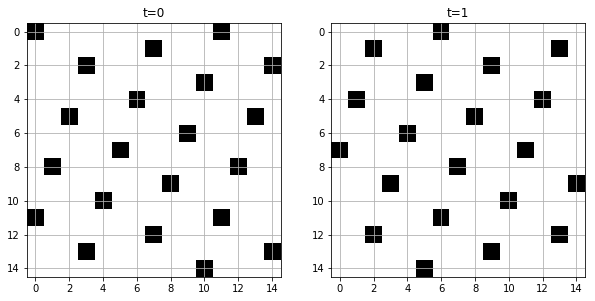

In [44]:
xxx=np.zeros((2,15,15))
xxxx=xxx.flatten()
xxxx[::11]=1
xtest=xxxx.reshape(2,15,15)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(xtest[0],cmap='binary')
plt.grid()
plt.title('t=0')
plt.subplot(122)
plt.imshow(xtest[1],cmap='binary')
plt.grid()
plt.title('t=1')
plt.show()

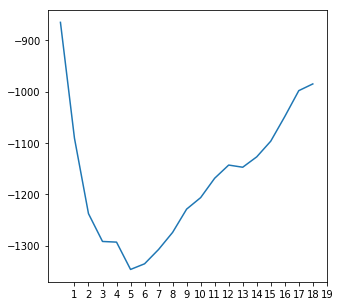

In [45]:
#Calcul du BIC

nbic=20
BIC=np.zeros((nbic-1))
for i in range(1,nbic,1):
    gmm_bic=mixture.GaussianMixture(n_components=i)
    gmm_bic.fit(data)
    BIC[i-1]=gmm_bic.bic(data[::11,:]) ##On prend une valeur sur 11 cf au dessus
    

plt.figure(figsize=(5,5))
plt.plot(BIC)
plt.xticks(np.arange(1,nbic,1))  
plt.show()

Il y a un minimum a 6, on test :

2.03158862952

 Mode/class/component/cluster ID# 0
center :  [ 0.11644221  0.13727186]
covariance :  [[ 0.00225544  0.00286976]
 [ 0.00286976  0.00394344]]
weight (prior) :  0.209640133469

 Mode/class/component/cluster ID# 1
center :  [ 0.55672515  0.03811095]
covariance :  [[  3.83859790e-02   1.02200109e-04]
 [  1.02200109e-04   9.00043875e-05]]
weight (prior) :  0.179674157261

 Mode/class/component/cluster ID# 2
center :  [ 0.378482    0.19580161]
covariance :  [[ 0.00734258 -0.00359272]
 [-0.00359272  0.00282468]]
weight (prior) :  0.12502600692

 Mode/class/component/cluster ID# 3
center :  [ 0.2299674   0.21240483]
covariance :  [[ 0.0032276  -0.00346364]
 [-0.00346364  0.00823995]]
weight (prior) :  0.25346080681

 Mode/class/component/cluster ID# 4
center :  [ 0.6148321   0.07621455]
covariance :  [[ 0.01805942 -0.00178716]
 [-0.00178716  0.00060121]]
weight (prior) :  0.088114716719

 Mode/class/component/cluster ID# 5
center :  [ 0.1540482   0.05516777]
covariance :  [[ 0.0

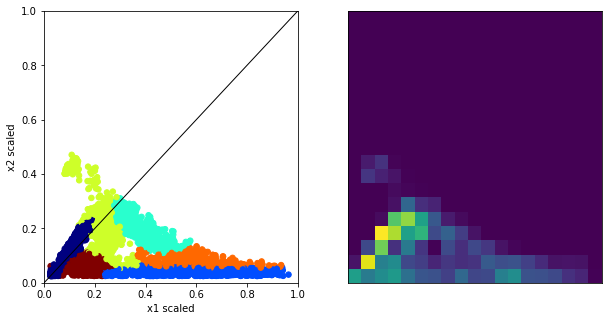

In [46]:
nb=1

data=np.array([X1_nozero[::nb]/maxplot,X2_nozero[::nb]/maxplot]).T


gmm6=mixture.GaussianMixture(n_components=6)
gmm6.fit(data)

#final log likehood of the dataset
print (gmm6.score(data))

k=0
for pos,covar,w in zip(gmm6.means_,gmm6.covariances_,gmm6.weights_):
    print ( '\n Mode/class/component/cluster ID#',k)
    print ( 'center : ',pos)
    print ( 'covariance : ',covar)
    print ( 'weight (prior) : ',w)
    k=k+1



posts6=gmm6.predict_proba(data)
labels6=gmm6.predict(data)

#print (labels)

plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
ax1.scatter(data[:,0], data[:,1],c=labels6,s=30,cmap='jet')
ax1.axis([0,1,0,1])
ax1.plot([-1,1],[-1,1],'-k',linewidth=1)
plt.xlabel('x1 scaled')
plt.ylabel('x2 scaled')

ax2 = plt.subplot(122)
x1_hist=np.linspace(0,1,N)
x2_hist=np.linspace(0,1,N)
H,xedges,yedges=np.histogram2d(data[:,1],data[:,0],bins=(x1_hist,x2_hist),normed=True)
ax2.pcolor(xedges,yedges,H,vmin=0,vmax=np.max(H))
plt.xticks([])
plt.yticks([])


plt.show()

Le résultat n'améliore pas fondamentalement le resultat car on a toujours la diagonale (des fois meme pas) : 4 classes est suffisant

-> Importance de l'expertise

### Phase predictive sur toute la zone (t  >200)

On fait la meme chose qu'au dessus dans toute la zone

In [49]:
# on reaplique le masque (le grand) sur les donnes

gradx_zeta_big=np.where(mask_grad[1:,1:]==1,gradx_zeta,0)
gradx_Tbar_big=np.where(mask_grad[1:,1:]==1,gradx_Tbar,0)
grady_zeta_big=np.where(mask_grad[1:,1:]==1,grady_zeta,0)
grady_Tbar_big=np.where(mask_grad[1:,1:]==1,grady_Tbar,0)
#calcul des normes
grad_zeta_big=np.sqrt(gradx_zeta_big**2+grady_zeta_big**2)
grad_Tbar_big=np.sqrt(gradx_Tbar_big**2+grady_Tbar_big**2)

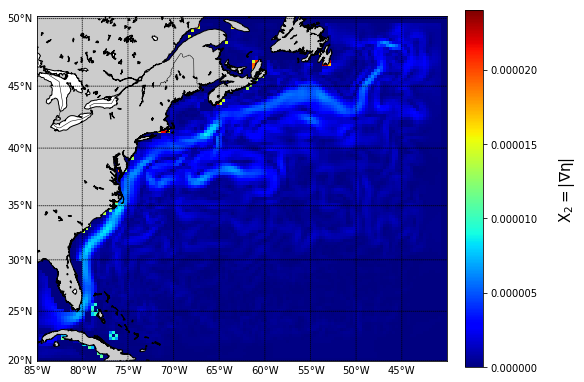

In [51]:
plt.figure(figsize=(8,8))
plt.subplot(111)
map = Basemap(llcrnrlon=lon_cut.min(),llcrnrlat=lat_cut.min(),urcrnrlon=lon_cut.max(),urcrnrlat=lat_cut.max(),resolution='i',projection='merc')
map.fillcontinents()
map.drawcoastlines()
map.drawcountries()
parallels = np.arange(lat_cut.min(),lat_cut.max(),5)
map.drawparallels(parallels,labels=[True,False,True,False])
meridians=np.arange(lon_cut.min(),lon_cut.max(),5)
map.drawmeridians(meridians,labels=[True,False,False,True])

xmap, ymap = map(lon, lat)


#pc=map.pcolormesh(xmap,ymap,np.where(grad_zeta[10,:,:]>0.00001,0,grad_zeta[10,:,:]),cmap='jet')#,vmin=0,vmax=0)
#pc=map.pcolormesh(xmap,ymap,grad_zeta[10,:,:],cmap='jet')#,vmin=0,vmax=0)
pc=map.pcolormesh(xmap,ymap,grad_zeta_big[150,:,:],cmap='jet')#,vmin=0,vmax=0)
cbar=plt.colorbar(pc,fraction=0.04, pad=0.04)
cbar.set_label(r"${\rm X_2=|\nabla \eta|}$ ", fontsize=15, rotation=90,labelpad=20)

plt.show()

(224, 32, 114, 136)


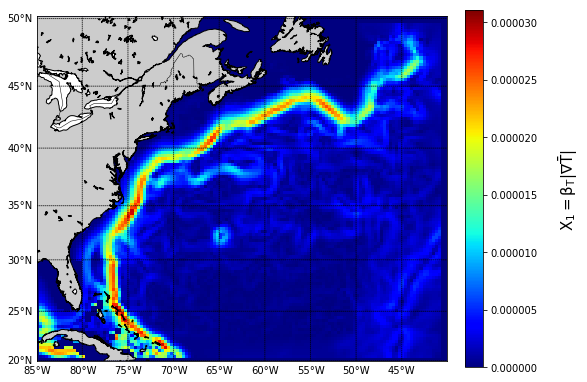

In [52]:
#from gsw import alpha_wrt_t_exact
import gsw

print(salt.shape)
salt_surf=np.copy(salt[:,31,:,:])

SA_surf=gsw.SA_from_SP(salt_surf,0,lon,lat)
beta=gsw.alpha_wrt_t_exact(salt_surf,temp[:,31,:,:],0)

beta=np.where(mask_grad[:,:]==1,beta,0)
beta=np.where(beta<0,0,beta)


plt.figure(figsize=(8,8))
plt.subplot(111)
map = Basemap(llcrnrlon=lon_cut.min(),llcrnrlat=lat_cut.min(),urcrnrlon=lon_cut.max(),urcrnrlat=lat_cut.max(),resolution='i',projection='merc')
map.fillcontinents()
map.drawcoastlines()
map.drawcountries()
parallels = np.arange(lat_cut.min(),lat_cut.max(),5)
map.drawparallels(parallels,labels=[True,False,True,False])
meridians=np.arange(lon_cut.min(),lon_cut.max(),5)
map.drawmeridians(meridians,labels=[True,False,False,True])

xmap, ymap = map(lon, lat)

#pc=map.pcolormesh(xmap,ymap,grad_Tbar[10,:,:],cmap='jet')#,vmin=0,vmax=0)
pc=map.pcolormesh(xmap,ymap,beta[150,1:,1:]*grad_Tbar_big[150,:,:],cmap='jet')#,vmin=0,vmax=0)
cbar=plt.colorbar(pc,fraction=0.04, pad=0.04)
cbar.set_label(r"${\rm X_1=\beta_T|\nabla \bar{T}|}$ ", fontsize=15, rotation=90,labelpad=20)

plt.show()

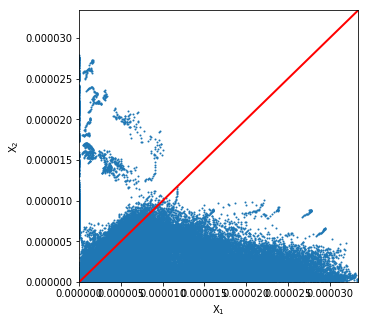

In [54]:
X1_big=grad_Tbar_big*beta[:,1:,1:] ###La premiere dimension
X2_big=grad_zeta_big[:,:,:] ### La deuxieme dimension

X1_flat_big=X1_big[200:,:,:].flatten()
X2_flat_big=X2_big[200:,:,:].flatten()
WHO_big=np.arange(len(X1_flat_big))

maxplot_big=np.max(np.absolute(np.array([np.min(X1_big),np.min(X2_big),np.max(X1_big),np.max(X2_big)])))

plt.figure(figsize=(5,5))

plt.plot(X1_flat_big,X2_flat_big,'o',markersize=1)

plt.plot([-1,1],[-1,1],'-r',linewidth=2)

plt.axis([0,maxplot,0,maxplot])

plt.xlabel(r'${\rm X_1}$')
plt.ylabel(r'${\rm X_2}$')

plt.show()

Toujours pareil meme ordre de grandeur pour les deux dimensions, mais plus de bruit a droite

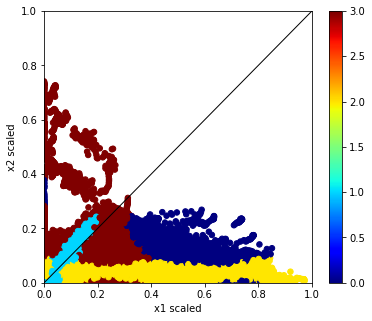

In [57]:
#On classe avec le GMM entrainé avec la petite zone

nb=1

data_big=np.array([X1_flat_big[::nb]/maxplot_big,X2_flat_big[::nb]/maxplot_big]).T


posts_big=gmm.predict_proba(data_big)
labels_big=gmm.predict(data_big)

#print (labels)

plt.figure(figsize=(6,5))
ax1 = plt.subplot(111)
plt.scatter(data_big[::,0], data_big[::,1],c=labels_big[::],s=30,cmap='jet')
plt.colorbar()
ax1.axis([0,1,0,1])
ax1.plot([-1,1],[-1,1],'-k',linewidth=1)
plt.xlabel('x1 scaled')
plt.ylabel('x2 scaled')

#ax2 = plt.subplot(122)
#x1_hist=np.linspace(0,1,N)
#x2_hist=np.linspace(0,1,N)
#H,xedges,yedges=np.histogram2d(data[:,1],data[:,0],bins=(x1_hist,x2_hist),normed=True)
#ax2.pcolor(xedges,yedges,H,vmin=0,vmax=np.max(H))
#plt.xticks([])
#plt.yticks([])


plt.show()

Memes pattern que sur la petite zone : on replace ca spatiallement

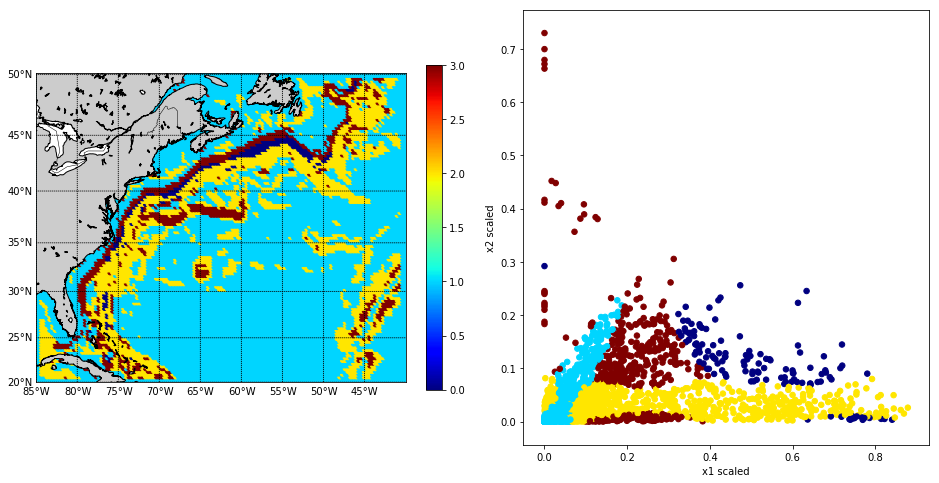

In [59]:
# on reshape le tableau de labels

labels_resh=labels_big.reshape(X1_big[200:,:].shape)


plt.figure(figsize=(16,8))
plt.subplot(121)
map = Basemap(llcrnrlon=lon_cut.min(),llcrnrlat=lat_cut.min(),urcrnrlon=lon_cut.max(),urcrnrlat=lat_cut.max(),resolution='i',projection='merc')
map.fillcontinents()
map.drawcoastlines()
map.drawcountries()
parallels = np.arange(lat_cut.min(),lat_cut.max(),5)
map.drawparallels(parallels,labels=[True,False,True,False])
meridians=np.arange(lon_cut.min(),lon_cut.max(),5)
map.drawmeridians(meridians,labels=[True,False,False,True])

xmap, ymap = map(lon, lat)

t=220
###Atention on a fait la classif a partir de 200 !! dans le tableau i=220-t

xclass_tmp=np.copy(xmap[1:,1:])
yclass_tmp=np.copy(ymap[1:,1:])

#xclass=xmap_tmp[labels_resh[t-200,:,:] ==2]
#yclass=ymap_tmp[labels_resh[t-200,:,:] ==2]

x_class=xclass_tmp.flatten()
y_class=yclass_tmp.flatten()




#pc=map.pcolormesh(xmap,ymap,grad_zeta_big[t,:,:],cmap='jet')#,vmin=0,vmax=0)
#cbar=plt.colorbar(pc,fraction=0.04, pad=0.04)
#cbar.set_label(r"$|\nabla \eta|$ ", fontsize=15, rotation=90,labelpad=20)

plt.scatter(x_class,y_class,c=labels_resh[t-200,:,:].flatten(),s=20,cmap='jet')
plt.colorbar(fraction=0.04)

plt.subplot(122)

plt.scatter(data_big[::50,0], data_big[::50,1],c=labels_big[::50],s=30,cmap='jet')
ax1.axis([0,1,0,1])
ax1.plot([-1,1],[-1,1],'-k',linewidth=1)
plt.xlabel('x1 scaled')
plt.ylabel('x2 scaled')



plt.show()

Problème des valeurs poubelles qui ont les gradients nuls : on les enleves 

Sur le petit set d'apprentissage on avait enlevé ces valeurs, on le fait ici aussi mais après avoir fait la classif

In [60]:
xclass_nozero=xclass_tmp[X1_big[t-200,:,:]>eps]
xclass_nozero=xclass_tmp[X2_big[t-200,:,:]>eps]
yclass_nozero=yclass_tmp[X1_big[t-200,:,:]>eps]
yclass_nozero=yclass_tmp[X2_big[t-200,:,:]>eps]
labels_resh_t=labels_resh[t-200,:,:]
labels_resh_nozero=labels_resh_t[X1_big[t-200,:,:]>eps]
labels_resh_nozero=labels_resh_t[X2_big[t-200,:,:]>eps]


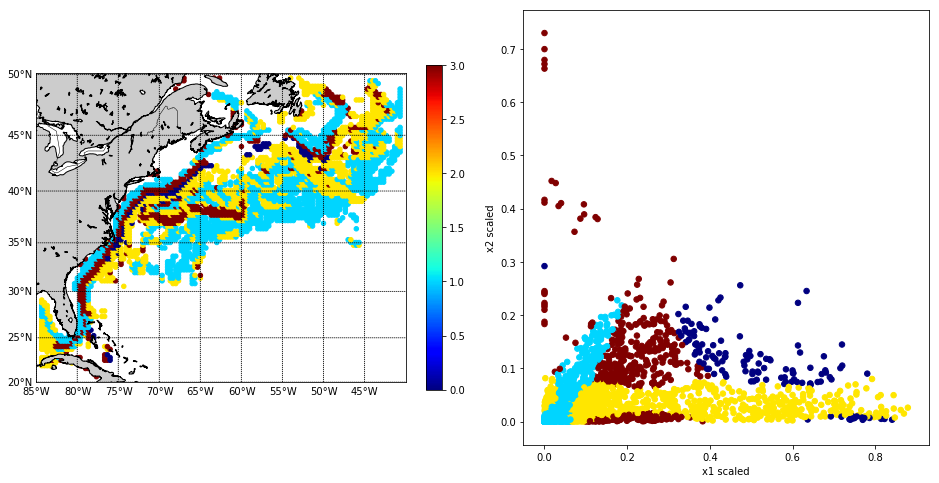

In [62]:
plt.figure(figsize=(16,8))
plt.subplot(121)
map = Basemap(llcrnrlon=lon_cut.min(),llcrnrlat=lat_cut.min(),urcrnrlon=lon_cut.max(),urcrnrlat=lat_cut.max(),resolution='i',projection='merc')
map.fillcontinents()
map.drawcoastlines()
map.drawcountries()
parallels = np.arange(lat_cut.min(),lat_cut.max(),5)
map.drawparallels(parallels,labels=[True,False,True,False])
meridians=np.arange(lon_cut.min(),lon_cut.max(),5)
map.drawmeridians(meridians,labels=[True,False,False,True])

xmap, ymap = map(lon, lat)


plt.scatter(xclass_nozero,yclass_nozero,c=labels_resh_nozero.flatten(),s=20,cmap='jet')
plt.colorbar(fraction=0.04)

plt.subplot(122)

plt.scatter(data_big[::50,0], data_big[::50,1],c=labels_big[::50],s=30,cmap='jet')

ax1.axis([0,1,0,1])
ax1.plot([-1,1],[-1,1],'-k',linewidth=1)
plt.xlabel('x1 scaled')
plt.ylabel('x2 scaled')


plt.show()

Pas très concluant : la classe diagonale semble pas correspondre aux modes géostrophiques

### On regarde une coupe meridienne pour regarder les profils verticaux associés à la classe

longitude de la coupe -70.0
lattitude de la coupe 31.9686
lattitude de la coupe 47.9665


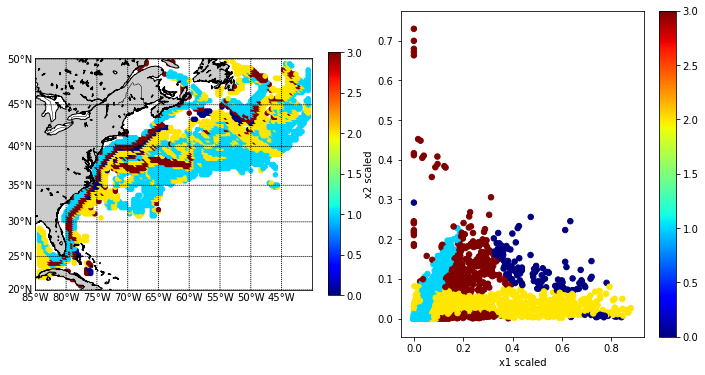

(32, 63)


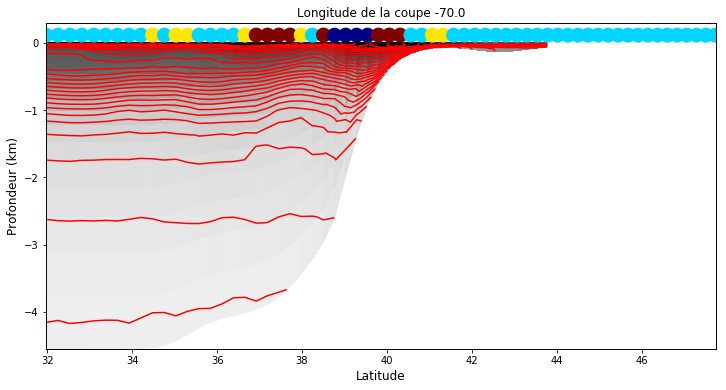

In [74]:
jour=200

z_r,z_w=zlevs(h,zeta[jour,:,:], hc, Cs_r, Cs_w)

idx_coupe_lon=45
idx_min_lat=40
idx_max_lat=103
print ("longitude de la coupe",lon[0,idx_coupe_lon])
print ("lattitude de la coupe",lat[idx_min_lat,0])
print ("lattitude de la coupe",lat[idx_max_lat,0])

z_r_cut=np.copy(z_r[:,idx_min_lat:idx_max_lat,idx_coupe_lon])
h_cut=np.copy(h[idx_min_lat:idx_max_lat,idx_coupe_lon])
lat_cut_cut=np.copy(lat[idx_min_lat:idx_max_lat,0])


temp_cut=np.copy(temp[jour,:,idx_min_lat:idx_max_lat,idx_coupe_lon])


labels_big_resh=labels_big.reshape(X1_big[200:].shape)
labels_big_cut=np.copy(labels_big_resh[jour-200,idx_min_lat:idx_max_lat,idx_coupe_lon])







plt.figure(figsize=(12,6))
plt.subplot(121)
map = Basemap(llcrnrlon=lon_cut.min(),llcrnrlat=lat_cut.min(),urcrnrlon=lon_cut.max(),urcrnrlat=lat_cut.max(),resolution='i',projection='merc')
map.fillcontinents()
map.drawcoastlines()
map.drawcountries()
parallels = np.arange(lat_cut.min(),lat_cut.max(),5)
map.drawparallels(parallels,labels=[True,False,True,False])
meridians=np.arange(lon_cut.min(),lon_cut.max(),5)
map.drawmeridians(meridians,labels=[True,False,False,True])

xmap, ymap = map(lon, lat)



plt.scatter(xclass_nozero,yclass_nozero,c=labels_resh_nozero.flatten(),s=20,cmap='jet')
plt.colorbar(fraction=0.04)

plt.subplot(122)

plt.scatter(data_big[::50,0], data_big[::50,1],c=labels_big[::50],s=30,cmap='jet')
plt.colorbar()
ax1.axis([0,1,0,1])
ax1.plot([-1,1],[-1,1],'-k',linewidth=1)
plt.xlabel('x1 scaled')
plt.ylabel('x2 scaled')

plt.show()



lat_cut_cut_tableau=np.zeros(z_r_cut.shape)
for i in range(32):
    lat_cut_cut_tableau[i,:]=lat_cut_cut


plt.figure(figsize=(12,6))
ax1=plt.subplot(111)
pc=plt.pcolormesh(lat_cut_cut_tableau,z_r_cut/1000.,temp_cut,cmap='binary')
pc=plt.contour(lat_cut_cut_tableau,z_r_cut/1000.,temp_cut,32,colors='red')#,cmap='binary')


plt.axis([np.min(lat_cut_cut),np.max(lat_cut_cut),np.min(z_r_cut/1000.),np.max(z_r_cut/1000.)+0.3])
plt.title("Longitude de la coupe {}".format(lon[0,idx_coupe_lon]))
plt.xlabel('Latitude',fontsize=12)
plt.ylabel('Profondeur (km)',fontsize=12)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cbar=fig.colorbar(pc, cax=cbar_ax)
cbar.set_label(r"Temperature ($^\circ$C)", fontsize=15, rotation=90,labelpad=20)

ax2=ax1.twinx()
plt.scatter(lat_cut_cut,labels_big_cut,c=labels_big_cut,s=100,linewidth=5,cmap='jet')
plt.yticks([])
plt.axis([np.min(lat_cut_cut),np.max(lat_cut_cut),-10000,400])
plt.show()


# Conclusion

On a repéré un front : youhou ?